Spark Master web UI: http://10.50.221.199:8080
Entering part 1


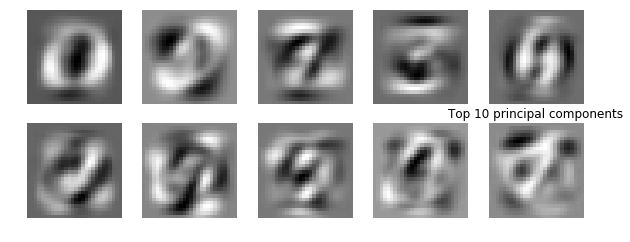

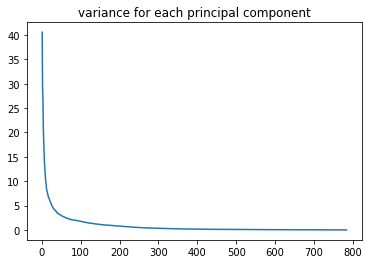

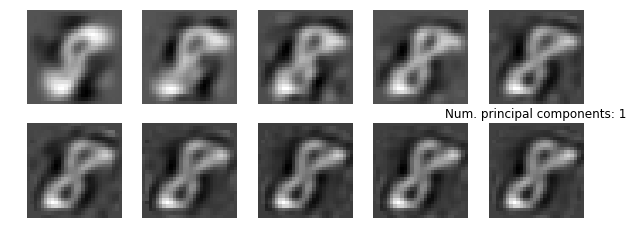

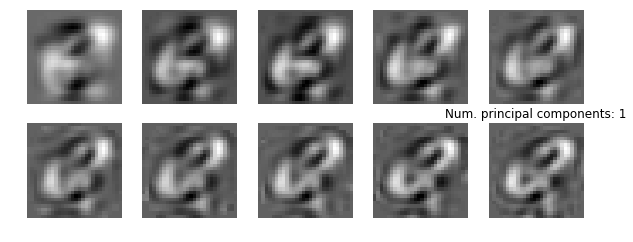

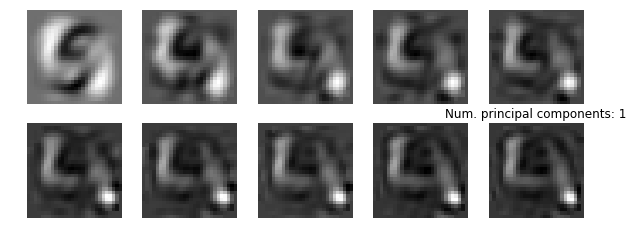

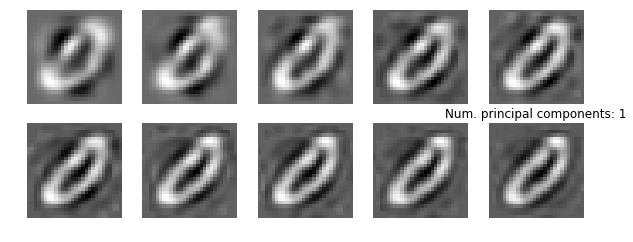

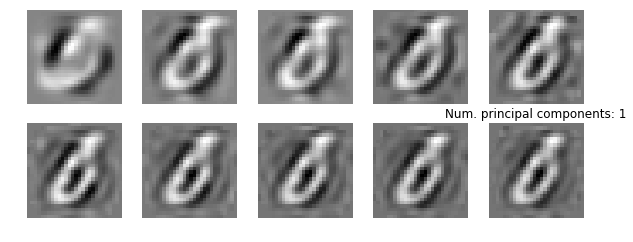

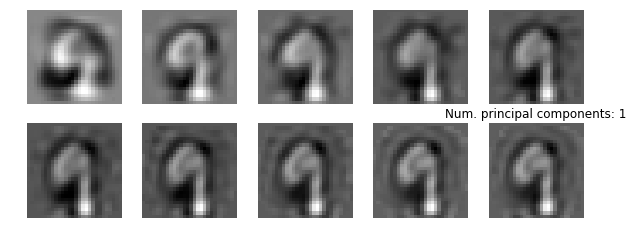

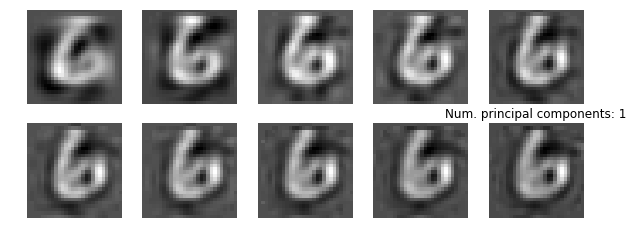

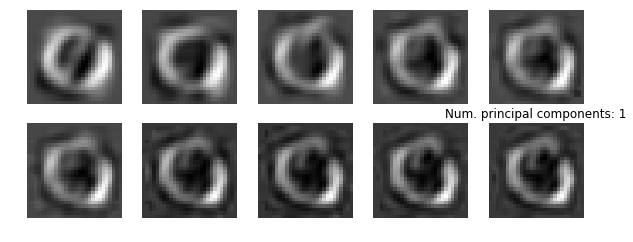

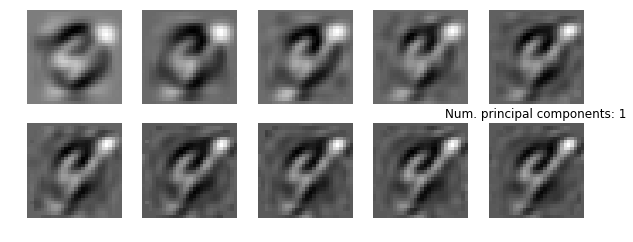

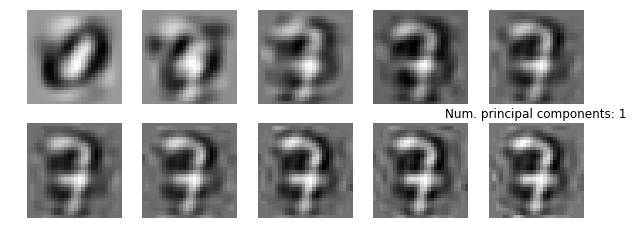

Getting results for component 10
Getting results for component 20
Getting results for component 30
Getting results for component 40
Getting results for component 50
Getting results for component 60
Getting results for component 70
Getting results for component 80
Getting results for component 90
Getting results for component 100


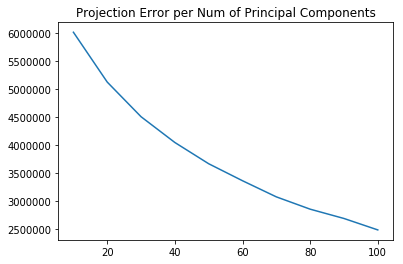

Entering part 2


/software/spark-2.1-el7-x86_64/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


Cluster num. 0 has primary label 8 : Samples of actual labels from cluster
[8, 5, 8, 5, 3, 8, 6, 5, 0, 8, 8, 8, 5, 0, 8, 5, 8, 0, 3, 3, 2, 2, 0, 6, 3, 8, 8, 5, 5, 8]
Percentage majority label: 0.366666666667
Cluster num. 1 has primary label 0 : Samples of actual labels from cluster
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Percentage majority label: 0.9
Cluster num. 2 has primary label 7 : Samples of actual labels from cluster
[7, 9, 5, 4, 4, 9, 7, 4, 9, 5, 7, 7, 4, 7, 4, 7, 4, 9, 4, 4, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Percentage majority label: 0.5
Cluster num. 3 has primary label 6 : Samples of actual labels from cluster
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 5, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6]
Percentage majority label: 0.866666666667
Cluster num. 4 has primary label 1 : Samples of actual labels from cluster
[1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 3, 9, 6, 1, 1, 2, 7, 2, 1]
Percentage majority labe

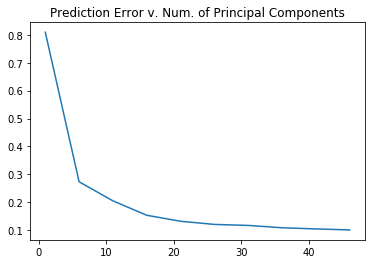

Selected k = 46 to minimize error at 0.101223776224
Error rate for model trained on training data: 0.0971153846154
Error rate for model trained on dev data: 0.0910839160839


0

In [1]:
### Part 3 ###

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pylab
import numpy as np
import os
import random
import math
import scipy
from scipy import linalg
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg.distributed import RowMatrix, IndexedRow, IndexedRowMatrix, CoordinateMatrix, BlockMatrix, MatrixEntry
from pyspark.mllib.feature import PCA

# Globals for visualize()
N_ROWS = 4
N_COLS = 5

NUM_PARTITIONS = 40

# Part 1 functions

# input: subset, an np array where the rows are digits
# input: title, plot title
# inputL savepath, filepath to save plot, Default None if user does not wish to save plot
def visualize(subset, title, savepath=None):
    nrows = 4
    ncols = 5

    plt.clf()
    pylab.figure() # clear plot
    plt.figure(figsize=(N_COLS*2, N_ROWS*2))

    #for i in xrange(nrows*ncols):
    for i in range(len(subset)):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(subset[i].reshape((28,28)), cmap='gray')
        plt.axis('off')

    plt.axis('off')
    plt.title(title)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

    return

# Returns every item in rdd with column label affixed in a flat list
def columnFlatMap(row):
    new_row = []
    features = row['features']
    for i in range(len(features)): # i is column index
        feature_list = []
        feature_list.append(features[i])
        new_row.append((i, feature_list))

    return new_row

# to be called with reduce by key
# returns reassembled vectors based on column index
def columnReduce(x, y): 
    if len(x) > len(y):
        for item in y:
            x.append(item)
        return x
    else:
        for item in x:
            y.append(item)
        return y


# Returns summary stats for columns of original data
def centerColumnMap(column):
    column_index = column[0] # get key from previous mapReduce
    mean = np.mean(column[1]) # get features
    std = np.std(column[1], dtype=np.float64)

    return (column_index, (mean, std))

# Returns: centered, UNLABELED data
# NOTE: cannot return labled data otherwise np.svd does not work
def centerMap(row, column_data_dict):
    label = row['label']
    features = row['features']

    centered_features = []
    for i in range(len(features)): # Center the data
        mean = column_data_dict[i][0]
        std = column_data_dict[i][1]
        if std != 0:
            centered_features.append((features[i] - mean) / std)
        else:
            centered_features.append(features[i] - mean)

    return centered_features

def centerWithLabelsMap(row, column_data_dict):
    label = row['label']
    features = row['features']

    centered_features = []
    for i in range(len(features)): # Center the data
        mean = column_data_dict[i][0]
        std = column_data_dict[i][1]
        if std != 0:
            centered_features.append((features[i] - mean) / std)
        else:
            centered_features.append(features[i] - mean)

    return (label, centered_features)

### Part 2 functions

# num components - num. principal components to be in returned matrix
# input is of shape d * d, where d is the number of columns in the data matrix X
# output is of form k * d, where k is the number of principal components # TODO: Make sure this is correct
def get_pc_matrix(num_components, eigenvectors):
    return eigenvectors[:,:num_components]

# input: principal component matrix, of shape k * d # TODO, make sure this is correct
# output: hat matrix, of shape k * d
def get_hat_matrix(pc_matrix):
    #hat_matrix = np.matmul(np.linalg.inv(np.matmul(pc_matrix, pc_matrix.transpose())), pc_matrix)
    pc_matrix_transpose = pc_matrix.transpose()
    hat_matrix = np.matmul(np.linalg.inv(np.matmul(pc_matrix_transpose, pc_matrix)), pc_matrix_transpose)
    return hat_matrix

# input hat_matrix, of shape k * d
# input point, of shape d * 1
# returns: parameters of projection: of form k * 1
def project_point(hat_matrix, point_t):
    return np.matmul(hat_matrix, point_t)

def stripLabelsMap(row):
    return row['features']

# input principal component matrix, of shape d * k
# projection parameters from project_point, of shape k * 1 
def transform_back_to_d(pc_t_matrix, proj_parameters):
    return np.matmul(pc_t_matrix, proj_parameters)

def projectionErrorMap(row, pc_matrix, hat_matrix):
    proj_parameters = project_point(hat_matrix, np.transpose(row))
    transformed_vector = transform_back_to_d(pc_matrix.transpose(), proj_parameters)

    squared_residual_sum = 0.0
    # calculate projection error
    for i in range(len(row)):
        difference = row[i] - transformed_vector[i]
        squared_residual_sum += (difference * difference)

    return squared_residual_sum

def projectionErrorReduce(x, y):
    return x + y

def predictionLabelReduce(x, y): # To be called with reduceByKey
    if len(x) > len(y):
        for item in y:
            x.append(item)
        return x
    else:
        for item in x:
            y.append(item)
        return y

def kMeansModelMap(row, clusters):
    predicted_label = clusters.predict(row['features'])
    actual_label_list = []
    actual_label_list.append(row['label'])
    return (predicted_label, actual_label_list)

# Part 2/3 K-Means functions
def getClusterLabelsDict(prediction_results):
    cluster_labels_dict = {}
    
    for key, cluster_list in prediction_results: # TODO: can probably combine with for loop below
        most_common_label = max(set(cluster_list), key=cluster_list.count) # get most common label
        cluster_labels_dict[key] = most_common_label
        
    return cluster_labels_dict

def visualizePredictionResults(cluster_labels_dict, prediction_results):
    sample_count = 30 # num samples from each cluster
    for key, cluster_list in prediction_results:
        # sample from cluster, visualize data
        index_set = set()
        for i in range(sample_count):
            rand_indx = random.randint(0, len(cluster_list) - 1)
            while rand_indx in index_set:
                rand_indx = random.randint(0, len(cluster_list) - 1)
            index_set.add(rand_indx)

        subset = []
        majority_count = 0.0
        subset_label = cluster_labels_dict[key] # TODO: the sampling here does not quite work
        for index in index_set:
            subset.append(cluster_list[index])
            if int(cluster_list[index]) == int(subset_label):
                majority_count += 1.0
        key_str = "Cluster num. " + str(key)
        subset_label_str = " has primary label " + str(subset_label)
        subset_str = " : Samples of actual labels from cluster"
        print key_str + subset_label_str + subset_str
        print subset
        print "Percentage majority label: " + str(float(majority_count) / float(sample_count))
        
    return


# Part 3 functions
def npArrayMap(row):
    return np.asarray(row['features'])

def similarityMatrixMap(row, h): # NOTE: to be used with uncentered data
    magnitude_row = np.linalg.norm(row[0] - row[1])
    calc_row = np.divide(np.multiply(-1.0, np.exp(magnitude_row)), h) 
    return calc_row

def labelMap(row):
    return row['label']

# Part 4 functions
def labeledPointMap(row):
    label = row['label']
    return LabeledPoint(row['label'], row['features'])

def delabelLabeledPointMap(row):
    return (row.label, row.features)

def errorRateMap(row):
    if int(row[0]) == int(row[1]):
        return (1, 1)
    else:
        return (0, 1)
    
def errorRateReduce(x, y):
    return (x[0] + y[0], x[1] + y[1])

def getFeaturesFromLabeledPointMap(row):
    return row.features

def getLabelFromLabeledPointMap(row):
    return row.label

def projectionMap(row, pc_matrix, hat_matrix):
    proj_parameters = project_point(hat_matrix, np.transpose(row))
    transformed_vector = transform_back_to_d(pc_matrix.transpose(), proj_parameters)
    return transformed_vector

def unlabeledColumnFlatMap(row):
    new_row = []
    for i in range(len(row)): # i is column index
        feature_list = []
        feature_list.append(row[i])
        new_row.append((i, feature_list))

    return new_row

def unlabeledCenterMap(row, column_data_dict):
    
    centered_features = []
    for i in range(len(row)): # Center the data
        mean = column_data_dict[i][0]
        std = column_data_dict[i][1]
        if std != 0:
            centered_features.append((row[i] - mean) / std)
        else:
            centered_features.append(row[i] - mean)

    return centered_features

def labeledPointMap(row):
    return LabeledPoint(row['label'], row['features'])

def zipToLabeledPointMap(row):
    return LabeledPoint(row[0], row[1])
        
############################################################

#os.system('start-spark-slurm.sh&') # use & to put it into background

# get ip address of this machine
ip = os.popen('hostname -i').read().strip('\n')
print 'Spark Master web UI: http://{}:8080'.format(ip)

spark = SparkSession.builder.master('local').appName('assn2').getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json').repartition(NUM_PARTITIONS) # TODO IMPORTANT CHANGED FOR DEBUG.

# part 1
print "Entering part 1"
# a)
column_data_dict = {} # indexed by column index
column_data = df.rdd.flatMap(columnFlatMap).reduceByKey(columnReduce).map(centerColumnMap).collect()
for key, value in column_data:
    column_data_dict[key] = value

centered_data_rdd = df.rdd.map(lambda row: centerMap(row, column_data_dict))
centered_train, centered_dev, centered_test = centered_data_rdd.randomSplit([4, 1, 1])

# Cov Matrix
mat = RowMatrix(centered_data_rdd)
cov_matrix = mat.computeCovariance().toArray()
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

components_to_visualize = 10
visualization_subset = []
for i in range(0, components_to_visualize):
    pc = eigen_vectors[:,i]
    visualization_subset.append(pc)

# VISUALIZATION
visualize(visualization_subset, title = "Top 10 principal components")

#b)
y_vector = []

for var in eigen_values:
    y_vector.append(var) 

x_vector = range(1, len(y_vector) + 1)  
plt.clf()
pylab.figure()
plt.title("variance for each principal component")
plt.plot(x_vector, y_vector)
plt.show()

#c)
components_to_test = 100 # test first x principal components
pc_matrix_arr = []
for i in range(10, components_to_test + 1, 10):
    pc_matrix = get_pc_matrix(i, eigen_vectors)
    pc_matrix_arr.append(pc_matrix)

# VISUALIZATION
num_to_sample = 10
sample = centered_test.takeSample(False, num_to_sample, seed=0)
point_arr = []
for row in sample:
    point_arr.append(np.transpose(row))

store = []
for point_t in point_arr:
    substore = []
    num_components = 1
    sub_title = "Num. principal components: " + str(num_components)
    for pc_matrix in pc_matrix_arr:
        hat_matrix = get_hat_matrix(pc_matrix)
        proj_parameters = project_point(hat_matrix, point_t)
        substore.append(transform_back_to_d(pc_matrix, proj_parameters))
    store.append((substore, sub_title))
    num_components += 1

# Visualize the elements in store, which are points -> [projections onto first k prin. components]
for substore, sub_title in store:
    visualize(substore, sub_title)


#d)
results_dict = {}
for i in range(10, components_to_test + 1, 10):
    index = (i - 1) / 10
    print "Getting results for component " + str(i)
    hat_matrix = get_hat_matrix(pc_matrix_arr[index])
    results_dict[index] = centered_test.map(lambda row:\
                                        projectionErrorMap(row, pc_matrix_arr[index].transpose(), hat_matrix)).\
                                        reduce(projectionErrorReduce)

# VISUALIZATION
x_vector = np.arange(10, components_to_test + 1, 10)
y_vector = []
for i in range(10, components_to_test + 1, 10):
    index = (i - 1) / 10
    y_vector.append(results_dict[index])

plt.clf()
pylab.figure() 
plt.title("Projection Error per Num of Principal Components")
plt.plot(x_vector, y_vector)
plt.show()

### Part 2 ###
print "Entering part 2"

p2_train = df

label_list = p2_train.rdd.map(labelMap).collect()

data_rdd = p2_train.rdd.map(stripLabelsMap)
clusters = KMeans.train(data_rdd, 10, maxIterations=50, runs=10, initializationMode="random")
    
prediction_results = p2_train.rdd.map(lambda row: kMeansModelMap(row, clusters)).reduceByKey(predictionLabelReduce).collect()
# maps cluster index to most common label in that cluster
cluster_labels_dict = getClusterLabelsDict(prediction_results) 
visualizePredictionResults(cluster_labels_dict, prediction_results)

# ### Part 3 ###

print "Entering part 3"
# h parameter
h = 2.0
# From Piazza suggesting only 2k-10k images

p3_subset, p3_test = df.rdd.map(npArrayMap).randomSplit([2,68])
saved_vec = p3_subset.collect()[0]
p3_subset = p3_subset.zipWithIndex()
p3_subset = p3_subset.map(lambda (val, idx): (idx, val))

idxs = range(p3_subset.count())
indices = spark.sparkContext.parallelize([(i,j) for i in idxs for j in idxs])
joined1 = indices.join(p3_subset).map(lambda (i, (j, val)): (j, (i, val)))
joined2 = joined1.join(p3_subset).map(lambda (j, ((i, pt1), pt2)): ((i,j), (np.asarray(pt1), np.asarray(pt2))))

similarity_rdd = joined2.mapValues(lambda (x, y): similarityMatrixMap((x, y), h))
similarity_matrix = CoordinateMatrix(similarity_rdd.map(lambda ((x,y),(d)): MatrixEntry(x,y,d))).toBlockMatrix().toLocalMatrix().toArray()

print
print "Created similarity matrix."
print

dim = idxs[-1] + 1
identity_matrix = np.identity(dim)
diag_sim_rdd = similarity_rdd.map(lambda (x,y): ((x[0], x[0]), y)).reduceByKey(lambda x,y: x + y).mapValues(lambda x: 1 / (x) ** 0.5)
diag_sim_matrix = np.nan_to_num(CoordinateMatrix(diag_sim_rdd.map(lambda ((x,y),(d)): MatrixEntry(x,y,d))).toBlockMatrix().toLocalMatrix().toArray())

sym_laplacian = np.subtract(identity_matrix, np.matmul(diag_sim_matrix, np.matmul(similarity_matrix, diag_sim_matrix)))

print "The bottom eigenvector of the normalized Laplacian corresponds to the eigenvalue 0."
print "The eigenvector can be calculated by multiplying D^1/2 matrix and a row vector of 1s."
print "The eigenvalue 1 of the Normalized Laplacian has the multiplicity of the eigenvalue 0 of the Similarity Matrix."

highest_eig = scipy.linalg.eigh(sym_laplacian, eigvals_only=True, eigvals=(0,1))[0]

training_laplacian = np.subtract(np.multiply(highest_eig, identity_matrix),sym_laplacian)
bottom_eigvals, bottom_eigvec = scipy.linalg.eigh(sym_laplacian, eigvals_only=False, eigvals=(0,4))
num_vectors = range(3, 5, 1)

for i in num_vectors:
    new_data = bottom_eigvec[:,1:i]
    new_data_t = np.transpose(new_data)
    proj_similarity_matrix = np.matmul(new_data,np.matmul(np.linalg.inv(np.matmul(new_data_t,new_data)),np.matmul(new_data_t, similarity_matrix)))
    train_matrix = spark.sparkContext.parallelize(proj_similarity_matrix)
    test_matrix = spark.sparkContext.parallelize(similarity_matrix)
    
    
    spectral_cluster_model = KMeans.train(train_matrix, 10, maxIterations=50, runs=10, initializationMode="random")
    comparison_model = KMeans.train(test_matrix, 10, maxIterations=50, runs=10, initializationMode="random")
    
    spectral_results = test_matrix.map(lambda row: spectral_cluster_model.predict(row)).collect()
    spectral_counts = {}
    for x in spectral_results:
        if x not in spectral_counts:
            spectral_counts[x] = 0
        spectral_counts[x] += 1
    
    comparison_results = test_matrix.map(lambda row: comparison_model.predict(row)).collect()
    comparison_counts = {}
    for x in comparison_results:
        if x not in comparison_counts:
            comparison_counts[x] = 0
        comparison_counts[x] += 1
    
    print spectral_counts
    print comparison_counts
print "It seems like spectral clustering did not detect the digits relative to traiditonal methods"

### Part 4 ###
print "Entering Part 4"

# part a
labeledPointRDD = df.rdd.map(labeledPointMap)
labeled_train, labeled_dev, labeled_test = labeledPointRDD.randomSplit([4, 1, 1])

num_iterations = 50
num_digits = 10 # 10 digits
model = LogisticRegressionWithLBFGS.train(labeled_train, iterations=num_iterations, numClasses=num_digits)

log_reg_results = labeled_test.map(lambda point: (point.label, model.predict(point.features))).map(errorRateMap).reduce(errorRateReduce)
error_rate = 1.0 - (float(log_reg_results[0]) / float(log_reg_results[1]))
print "Error rate for full features: " + str(error_rate)

# part b

results_dict = {}
k_range = range(1, 50+1, 5)

train_labels_rdd = labeled_train.map(getLabelFromLabeledPointMap)
train_delabeled_rdd = labeled_train.map(getFeaturesFromLabeledPointMap)
test_labels_rdd = labeled_test.map(getLabelFromLabeledPointMap)
test_delabeled_rdd = labeled_test.map(getFeaturesFromLabeledPointMap)
dev_labels_rdd = labeled_dev.map(getLabelFromLabeledPointMap)
dev_delabeled_rdd = labeled_dev.map(getFeaturesFromLabeledPointMap)

for k in k_range:
    pca_model = PCA(k=k).fit(train_delabeled_rdd)
    projected_train_rdd = pca_model.transform(train_delabeled_rdd)
    relabeled_proj_train_rdd = train_labels_rdd.zip(projected_train_rdd)
    labeled_points_proj_train_rdd = relabeled_proj_train_rdd.map(zipToLabeledPointMap)
    
    projected_test_rdd = pca_model.transform(test_delabeled_rdd)
    relabeled_proj_test_rdd = test_labels_rdd.zip(projected_test_rdd)
    labeled_points_proj_test_rdd = relabeled_proj_test_rdd.map(zipToLabeledPointMap)
    
    num_iterations = 25
    num_digits = 10 # 10 digits
    model = LogisticRegressionWithLBFGS.train(labeled_points_proj_train_rdd, iterations=num_iterations,
                                                numClasses=num_digits)

    log_reg_results = labeled_points_proj_test_rdd.map(lambda point: (point.label, model.predict(point.features))).\
                                                        map(errorRateMap).reduce(errorRateReduce)
                                    
    error_rate = 1.0 - (float(log_reg_results[0]) / float(log_reg_results[1]))
    results_dict[k] = error_rate
    print "Error rate for " + str(k) + ": " + str(error_rate)

# VISUALIZATION
x_vector = k_range
y_vector = []
for i in k_range:
    y_vector.append(results_dict[i])

plt.clf()
pylab.figure() 
plt.title("Prediction Error v. Num. of Principal Components")
plt.plot(x_vector, y_vector)
plt.show()
    
# part c:
lowest_pc_error = 1.1
lowest_pc_key = 0.0
for key, value in results_dict.items():
    if value < lowest_pc_error:
        lowest_pc_error = value
        lowest_pc_key = key

print "Selected k = " + str(lowest_pc_key) + " to minimize error at " + str(lowest_pc_error)
        
num_iterations = 50
num_digits = 10 # 10 digits

train_pca_model = PCA(lowest_pc_key).fit(train_delabeled_rdd)
projected_train_rdd = train_pca_model.transform(train_delabeled_rdd)
relabeled_proj_train_rdd = train_labels_rdd.zip(projected_train_rdd)
labeled_points_proj_train_rdd = relabeled_proj_train_rdd.map(zipToLabeledPointMap)

projected_train_test_rdd = train_pca_model.transform(test_delabeled_rdd)
relabeled_proj_train_test_rdd = test_labels_rdd.zip(projected_train_test_rdd)
labeled_points_proj_train_test_rdd = relabeled_proj_train_test_rdd.map(zipToLabeledPointMap)

train_model = LogisticRegressionWithLBFGS.train(labeled_points_proj_train_rdd, iterations=num_iterations,
                                                numClasses=num_digits)
train_log_reg_results = labeled_points_proj_train_test_rdd.map(lambda point: \
                                                               (point.label, train_model.predict(point.features))).\
                                                                map(errorRateMap).reduce(errorRateReduce)
train_error_rate = 1.0 - (float(train_log_reg_results[0]) / float(train_log_reg_results[1]))
print "Error rate for model trained on training data: " + str(train_error_rate)

dev_pca_model = PCA(lowest_pc_key).fit(dev_delabeled_rdd)
projected_dev_rdd = dev_pca_model.transform(dev_delabeled_rdd)
relabeled_proj_dev_rdd = dev_labels_rdd.zip(projected_dev_rdd)
labeled_points_dev_dev_rdd = relabeled_proj_dev_rdd.map(zipToLabeledPointMap)

projected_dev_test_rdd = dev_pca_model.transform(test_delabeled_rdd)
relabeled_proj_dev_test_rdd = test_labels_rdd.zip(projected_dev_test_rdd)
labeled_points_proj_dev_test_rdd = relabeled_proj_dev_test_rdd.map(zipToLabeledPointMap)

dev_model = LogisticRegressionWithLBFGS.train(labeled_points_proj_dev_test_rdd, iterations=num_iterations, numClasses=num_digits)

dev_log_reg_results = labeled_points_proj_dev_test_rdd.map(lambda point: \
                                                            (point.label, dev_model.predict(point.features))).\
                                                            map(errorRateMap).reduce(errorRateReduce)
dev_error_rate = 1.0 - (float(dev_log_reg_results[0]) / float(dev_log_reg_results[1]))
print "Error rate for model trained on dev data: " + str(dev_error_rate)

spark.stop()
os.system('stop-spark-slurm.sh')